In [2]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from loader import get_train_loader

In [3]:
image_h, image_w = 128, 128

In [4]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class Transpose(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), 16, 4, 4)

In [9]:
dimZ = 256

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=2, padding=0),
#             nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=2, padding=1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.ReLU(),
            
            nn.Conv2d(32, 32, kernel_size=2, padding=0),
#             nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=2, padding=1),
#             nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.ReLU(),
            
            nn.Conv2d(32, 32, kernel_size=2, padding=0),
#             nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=2, padding=1),
#             nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.ReLU(),
            
            nn.Conv2d(32, 32, kernel_size=2, padding=0),
#             nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=2, padding=1),
#             nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.ReLU(),
            
            nn.Conv2d(32, 32, kernel_size=2, padding=1),
#             nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.ReLU(),
#             Flatten(),
#             nn.Linear(256, dimZ),
#             nn.BatchNorm1d(dimZ),
#             nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
#             nn.Linear(dimZ, 256),
#             nn.BatchNorm1d(256),
#             nn.ReLU(),
            
#             Transpose(), # TODO: write transpose layer
            nn.ConvTranspose2d(32, 32, 2, stride=2),
#             nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 2, stride=2),
#             nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.Conv2d(32, 32, kernel_size=2, padding=0),
#             nn.BatchNorm2d(32),
            nn.ReLU(),
            
            
            nn.ConvTranspose2d(32, 32, 2, stride=2),
#             nn.BatchNorm2d(32),
            nn.ReLU(),
            
            
            nn.Conv2d(32, 32, kernel_size=2, padding=1),
#             nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.ConvTranspose2d(32, 3, 2, stride=2),
#             nn.BatchNorm2d(3),
            nn.ReLU(),
            
            nn.Conv2d(3, 3, kernel_size=3, padding=2),
#             nn.BatchNorm2d(3),
            
            nn.Sigmoid(),
#             nn.ConvTranspose2d(32, 32, 3, stride=2),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(3),
#             nn.ReLU(),
        )
#         nn.init.xavier_uniform(list(self.parameters())[0])
#         nn.init.constant(list(self.parameters())[1], 0)
#         nn.init.xavier_uniform(list(self.parameters())[4])
#         nn.init.constant(list(self.parameters())[5], 0)
#         nn.init.xavier_uniform(list(self.parameters())[8])
#         nn.init.constant(list(self.parameters())[9], 0)
#         nn.init.xavier_uniform(list(self.parameters())[12])
#         nn.init.constant(list(self.parameters())[13], 0)
        
    def forward(self, x):
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        return reconstruction, latent_code

In [10]:
# Create MSE loss function
criterion = torch.nn.MSELoss()

autoencoder = Autoencoder().cuda()

# Use Adam optimizer
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

In [7]:
train_loader, val_loader = get_train_loader("../deepfashion/index.p", batch_size=64, resize_size=128)

In [11]:
# Train your autoencoder
# Visualize progress in reconstruction and loss decay

train_loss = []
val_loss = []
reconstructed_pictures = []

import time
num_epochs = 100 # total amount of full passes over training data

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    autoencoder.train(True) # enable dropout / batch_norm training behavior
    i = 0
    for X_batch, y_batch in train_loader:
        i += 1
        # train on batch
        X_batch_0 = torch.FloatTensor(X_batch[:, 0])
        X_batch_0 = Variable(X_batch_0).cuda()
#         X_batch = Variable(X_batch)
#         y_batch = Variable(y_batch)
        output_img, _ = autoencoder(X_batch_0)
        loss = criterion(output_img, X_batch_0)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss.append(loss.cpu().data.numpy()[0])
#         train_loss.append(loss.data.numpy())
        
        X_batch_1 = torch.FloatTensor(X_batch[:, 1])
        X_batch_1 = Variable(X_batch_1).cuda()
        output_img, _ = autoencoder(X_batch_1)
        loss = criterion(output_img, X_batch_1)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss.append(loss.cpu().data.numpy()[0])
#         train_loss.append(loss.data.numpy())
#         print(i, ":", loss.data.cpu().numpy()[0], end=", ")

    # And a full pass over the validation data:
    autoencoder.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in val_loader:
        X_batch_0 = Variable(X_batch[:, 0]).cuda()
        output_img, _ = autoencoder(X_batch_0)
        val_loss.append(criterion(output_img, X_batch_0).cpu().data.numpy()[0])
        X_batch_1 = Variable(X_batch[:, 1]).cuda()
        output_img, _ = autoencoder(X_batch_1)
        val_loss.append(criterion(output_img, X_batch_1).cpu().data.numpy()[0])
#         val_loss.append(criterion(output_img, X_batch).data.numpy())
#     if epoch % 16 == 0:
#         X_batch = Variable(torch.FloatTensor(np.array([X_val[247]]))).cuda()
#         output_img, _ = autoencoder(X_batch)
#         # reconstructed_pictures.append(output_img.cpu().data.numpy()[0])
#         reconstructed_pictures.append(output_img.data.numpy())
    # Then we print the results for this epoch:
    print 
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-2 * len(train_loader):])))
    print("  validation loss: \t\t\t{:.6f}".format(
        np.mean(val_loss[-2 * len(val_loader):])))

Epoch 1 of 100 took 101.584s
  training loss (in-iteration): 	0.045208
  validation loss: 			0.020248
Epoch 2 of 100 took 97.451s
  training loss (in-iteration): 	0.017960
  validation loss: 			0.017380
Epoch 3 of 100 took 98.644s
  training loss (in-iteration): 	0.016012
  validation loss: 			0.015868
Epoch 4 of 100 took 97.976s
  training loss (in-iteration): 	0.014510
  validation loss: 			0.014797
Epoch 5 of 100 took 98.557s
  training loss (in-iteration): 	0.013253
  validation loss: 			0.014069
Epoch 6 of 100 took 98.844s
  training loss (in-iteration): 	0.012161
  validation loss: 			0.013010
Epoch 7 of 100 took 98.656s
  training loss (in-iteration): 	0.011226
  validation loss: 			0.012182
Epoch 8 of 100 took 97.232s
  training loss (in-iteration): 	0.010457
  validation loss: 			0.011892
Epoch 9 of 100 took 113.661s
  training loss (in-iteration): 	0.009823
  validation loss: 			0.011148


KeyboardInterrupt: 

In [32]:
dimZ = 256

class Autoencoder4(nn.Module):
    def __init__(self):
        super(Autoencoder4, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=2, padding=0),
#             nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=2, padding=1),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 16, 2, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 3, kernel_size=3, padding=1),
            
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        return reconstruction, latent_code

In [33]:
# Create MSE loss function
criterion = torch.nn.MSELoss()

autoencoder = Autoencoder4().cuda()

# Use Adam optimizer
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

In [34]:
train_loader, val_loader = get_train_loader("../deepfashion/index.p", batch_size=64, resize_size=8)

In [35]:
# Train your autoencoder
# Visualize progress in reconstruction and loss decay

train_loss = []
val_loss = []
reconstructed_pictures = []

import time
num_epochs = 100 # total amount of full passes over training data

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    autoencoder.train(True) # enable dropout / batch_norm training behavior
    i = 0
    for X_batch, y_batch in train_loader:
        i += 1
        # train on batch
        X_batch_0 = torch.FloatTensor(X_batch[:, 0])
        X_batch_0 = Variable(X_batch_0).cuda()
#         X_batch = Variable(X_batch)
#         y_batch = Variable(y_batch)
        output_img, _ = autoencoder(X_batch_0)
        loss = criterion(output_img, X_batch_0)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss.append(loss.cpu().data.numpy()[0])
#         train_loss.append(loss.data.numpy())
        
        X_batch_1 = torch.FloatTensor(X_batch[:, 1])
        X_batch_1 = Variable(X_batch_1).cuda()
#         X_batch = Variable(X_batch)
#         y_batch = Variable(y_batch)
        output_img, _ = autoencoder(X_batch_1)
        loss = criterion(output_img, X_batch_1)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss.append(loss.cpu().data.numpy()[0])
#         train_loss.append(loss.data.numpy())
#         print(i, ":", loss.data.cpu().numpy()[0], end=", ")

    # And a full pass over the validation data:
    autoencoder.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in val_loader:
        X_batch_0 = Variable(X_batch[:, 0]).cuda()
        output_img, _ = autoencoder(X_batch_0)
        val_loss.append(criterion(output_img, X_batch_0).cpu().data.numpy()[0])
        X_batch_1 = Variable(X_batch[:, 1]).cuda()
        output_img, _ = autoencoder(X_batch_1)
        val_loss.append(criterion(output_img, X_batch_1).cpu().data.numpy()[0])
#         val_loss.append(criterion(output_img, X_batch).data.numpy())
#     if epoch % 16 == 0:
#         X_batch = Variable(torch.FloatTensor(np.array([X_val[247]]))).cuda()
#         output_img, _ = autoencoder(X_batch)
#         # reconstructed_pictures.append(output_img.cpu().data.numpy()[0])
#         reconstructed_pictures.append(output_img.data.numpy())
    # Then we print the results for this epoch:
    print 
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-2 * len(train_loader):])))
    print("  validation loss: \t\t\t{:.6f}".format(
        np.mean(val_loss[-2 * len(val_loader):])))

Epoch 1 of 100 took 56.348s
  training loss (in-iteration): 	0.017195
  validation loss: 			0.006959
Epoch 2 of 100 took 55.468s
  training loss (in-iteration): 	0.004702
  validation loss: 			0.002406
Epoch 3 of 100 took 55.484s
  training loss (in-iteration): 	0.001873
  validation loss: 			0.001438
Epoch 4 of 100 took 55.467s
  training loss (in-iteration): 	0.001368
  validation loss: 			0.001147
Epoch 5 of 100 took 55.524s
  training loss (in-iteration): 	0.001146
  validation loss: 			0.001000
Epoch 6 of 100 took 56.252s
  training loss (in-iteration): 	0.001021
  validation loss: 			0.000909
Epoch 7 of 100 took 56.680s
  training loss (in-iteration): 	0.000938
  validation loss: 			0.000831
Epoch 8 of 100 took 54.816s
  training loss (in-iteration): 	0.000880
  validation loss: 			0.000788
Epoch 9 of 100 took 55.407s
  training loss (in-iteration): 	0.000835
  validation loss: 			0.000748
Epoch 10 of 100 took 55.228s
  training loss (in-iteration): 	0.000797
  validation loss: 	

KeyboardInterrupt: 

In [36]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    scale_const = 1.2
    plt.figure(figsize=(3 / scale_const * n_col, 3.4 / scale_const * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].numpy().transpose(1,2,0), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

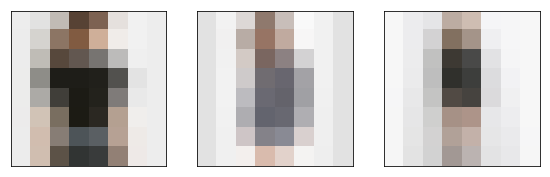

In [53]:
plot_gallery(X_batch[:3, 1], image_h, image_w, n_row=1, n_col=3)

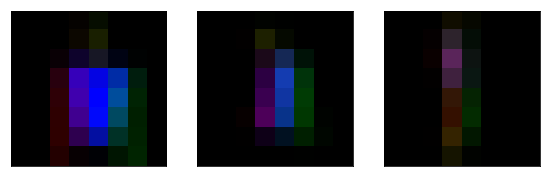

In [56]:
plot_gallery(y_batch[:3, 0], image_h, image_w, n_row=1, n_col=3)

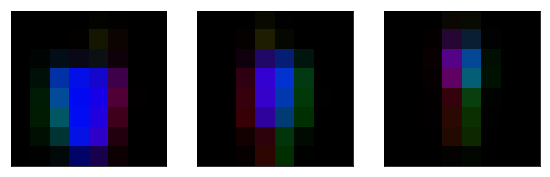

In [55]:
plot_gallery(autoencoder(Variable(y_batch[:3, 1]).cuda())[0].cpu().data, image_h, image_w, n_row=1, n_col=3)

In [42]:
torch.save(autoencoder, "autoencoder.people.4.pt")

/home/koloskov/anaconda3/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type Autoencoder4. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Train stickmans

In [45]:
# Create MSE loss function
criterion = torch.nn.MSELoss()

autoencoder = Autoencoder4().cuda()

# Use Adam optimizer
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

In [46]:
# Train your autoencoder
# Visualize progress in reconstruction and loss decay

train_loss = []
val_loss = []
reconstructed_pictures = []

import time
num_epochs = 100 # total amount of full passes over training data

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    autoencoder.train(True) # enable dropout / batch_norm training behavior
    i = 0
    for X_batch, y_batch in train_loader:
        i += 1
        # train on batch
        X_batch_0 = torch.FloatTensor(y_batch[:, 0])
        X_batch_0 = Variable(X_batch_0).cuda()
#         X_batch = Variable(X_batch)
#         y_batch = Variable(y_batch)
        output_img, _ = autoencoder(X_batch_0)
        loss = criterion(output_img, X_batch_0)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss.append(loss.cpu().data.numpy()[0])
#         train_loss.append(loss.data.numpy())
        
        X_batch_1 = torch.FloatTensor(y_batch[:, 1])
        X_batch_1 = Variable(X_batch_1).cuda()
#         X_batch = Variable(X_batch)
#         y_batch = Variable(y_batch)
        output_img, _ = autoencoder(X_batch_1)
        loss = criterion(output_img, X_batch_1)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss.append(loss.cpu().data.numpy()[0])
#         train_loss.append(loss.data.numpy())
#         print(i, ":", loss.data.cpu().numpy()[0], end=", ")

    # And a full pass over the validation data:
    autoencoder.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in val_loader:
        X_batch_0 = Variable(y_batch[:, 0]).cuda()
        output_img, _ = autoencoder(X_batch_0)
        val_loss.append(criterion(output_img, X_batch_0).cpu().data.numpy()[0])
        X_batch_1 = Variable(y_batch[:, 1]).cuda()
        output_img, _ = autoencoder(X_batch_1)
        val_loss.append(criterion(output_img, X_batch_1).cpu().data.numpy()[0])
#         val_loss.append(criterion(output_img, X_batch).data.numpy())
#     if epoch % 16 == 0:
#         X_batch = Variable(torch.FloatTensor(np.array([X_val[247]]))).cuda()
#         output_img, _ = autoencoder(X_batch)
#         # reconstructed_pictures.append(output_img.cpu().data.numpy()[0])
#         reconstructed_pictures.append(output_img.data.numpy())
    # Then we print the results for this epoch:
    print 
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-2 * len(train_loader):])))
    print("  validation loss: \t\t\t{:.6f}".format(
        np.mean(val_loss[-2 * len(val_loader):])))

Epoch 1 of 100 took 55.506s
  training loss (in-iteration): 	0.031539
  validation loss: 			0.004092
Epoch 2 of 100 took 55.456s
  training loss (in-iteration): 	0.002874
  validation loss: 			0.002067
Epoch 3 of 100 took 54.498s
  training loss (in-iteration): 	0.001614
  validation loss: 			0.001265
Epoch 4 of 100 took 54.376s
  training loss (in-iteration): 	0.001009
  validation loss: 			0.000900
Epoch 5 of 100 took 54.630s
  training loss (in-iteration): 	0.000739
  validation loss: 			0.000708
Epoch 6 of 100 took 56.645s
  training loss (in-iteration): 	0.000610
  validation loss: 			0.000601
Epoch 7 of 100 took 57.803s
  training loss (in-iteration): 	0.000534
  validation loss: 			0.000539
Epoch 8 of 100 took 60.079s
  training loss (in-iteration): 	0.000481
  validation loss: 			0.000479
Epoch 9 of 100 took 60.249s
  training loss (in-iteration): 	0.000442
  validation loss: 			0.000445
Epoch 10 of 100 took 58.670s
  training loss (in-iteration): 	0.000405
  validation loss: 	

Epoch 82 of 100 took 56.259s
  training loss (in-iteration): 	0.000084
  validation loss: 			0.000112
Epoch 83 of 100 took 56.090s
  training loss (in-iteration): 	0.000083
  validation loss: 			0.000111
Epoch 84 of 100 took 56.727s
  training loss (in-iteration): 	0.000083
  validation loss: 			0.000112
Epoch 85 of 100 took 56.003s
  training loss (in-iteration): 	0.000083
  validation loss: 			0.000113
Epoch 86 of 100 took 56.760s
  training loss (in-iteration): 	0.000083
  validation loss: 			0.000113
Epoch 87 of 100 took 55.806s
  training loss (in-iteration): 	0.000082
  validation loss: 			0.000114
Epoch 88 of 100 took 54.700s
  training loss (in-iteration): 	0.000082
  validation loss: 			0.000114
Epoch 89 of 100 took 60.102s
  training loss (in-iteration): 	0.000082
  validation loss: 			0.000113
Epoch 90 of 100 took 60.198s
  training loss (in-iteration): 	0.000081
  validation loss: 			0.000113


TypeError: int() argument must be a string, a bytes-like object or a number, not 'JpegImageFile'

In [47]:
autoencoder.train(False)

Autoencoder4(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
    (3): Conv2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Sigmoid()
  )
)

In [48]:
torch.save(autoencoder, "autoencoder.stickmen.4.pt")

/home/koloskov/anaconda3/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type Autoencoder4. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


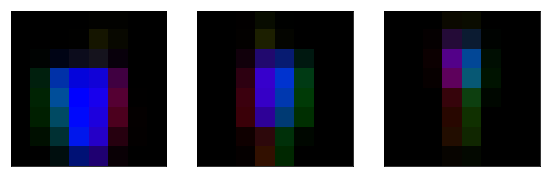

In [50]:
plot_gallery(y_batch[:3, 1], image_h, image_w, n_row=1, n_col=3)

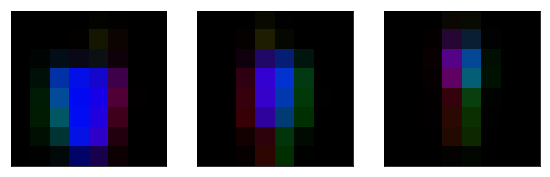

In [51]:
plot_gallery(autoencoder(Variable(y_batch[:3, 1]).cuda())[0].cpu().data, image_h, image_w, n_row=1, n_col=3)

In [38]:
autoencoder(Variable(X_batch[:3, 1]).cuda())[1].cpu().data.shape

torch.Size([3, 16, 4, 4])

In [ ]:
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-4)

In [120]:
# Train your autoencoder
# Visualize progress in reconstruction and loss decay

train_loss = []
val_loss = []
reconstructed_pictures = []

import time
num_epochs = 1 # total amount of full passes over training data

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    autoencoder.train(True) # enable dropout / batch_norm training behavior
    i = 0
    for X_batch, y_batch in train_loader:
        i += 1
        # train on batch
        X_batch_0 = torch.FloatTensor(X_batch[:, 0])
        X_batch_0 = Variable(X_batch_0).cuda()
#         X_batch = Variable(X_batch)
#         y_batch = Variable(y_batch)
        output_img, _ = autoencoder(X_batch_0)
        loss = criterion(output_img, X_batch_0)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss.append(loss.cpu().data.numpy()[0])
#         train_loss.append(loss.data.numpy())
        
        X_batch_1 = torch.FloatTensor(X_batch[:, 1])
        X_batch_1 = Variable(X_batch_1).cuda()
#         X_batch = Variable(X_batch)
#         y_batch = Variable(y_batch)
        output_img, _ = autoencoder(X_batch_1)
        loss = criterion(output_img, X_batch_1)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss.append(loss.cpu().data.numpy()[0])
#         train_loss.append(loss.data.numpy())
#         print(i, ":", loss.data.cpu().numpy()[0], end=", ")

    # And a full pass over the validation data:
    autoencoder.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in val_loader:
        X_batch_0 = Variable(X_batch[:, 0]).cuda()
        output_img, _ = autoencoder(X_batch_0)
        val_loss.append(criterion(output_img, X_batch_0).cpu().data.numpy()[0])
        X_batch_1 = Variable(X_batch[:, 1]).cuda()
        output_img, _ = autoencoder(X_batch_1)
        val_loss.append(criterion(output_img, X_batch_1).cpu().data.numpy()[0])
#         val_loss.append(criterion(output_img, X_batch).data.numpy())
#     if epoch % 16 == 0:
#         X_batch = Variable(torch.FloatTensor(np.array([X_val[247]]))).cuda()
#         output_img, _ = autoencoder(X_batch)
#         # reconstructed_pictures.append(output_img.cpu().data.numpy()[0])
#         reconstructed_pictures.append(output_img.data.numpy())
    # Then we print the results for this epoch:
    print 
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-2 * len(train_loader):])))
    print("  validation loss: \t\t\t{:.6f}".format(
        np.mean(val_loss[-2 * len(val_loader):])))

Epoch 1 of 1 took 100.482s
  training loss (in-iteration): 	0.003360
  validation loss: 			0.003582


In [127]:
torch.save(autoencoder, "autoencoder2.pt")

/home/koloskov/anaconda3/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type Autoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [27]:
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-4)

In [ ]:
# Train your autoencoder
# Visualize progress in reconstruction and loss decay

train_loss = []
val_loss = []
reconstructed_pictures = []

import time
num_epochs = 10 # total amount of full passes over training data

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    autoencoder.train(True) # enable dropout / batch_norm training behavior
    i = 0
    for X_batch, y_batch in train_loader:
        i += 1
        # train on batch
        X_batch_0 = torch.FloatTensor(X_batch[:, 0])
        X_batch_0 = Variable(X_batch_0).cuda()
#         X_batch = Variable(X_batch)
#         y_batch = Variable(y_batch)
        output_img, _ = autoencoder(X_batch_0)
        loss = criterion(output_img, X_batch_0)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss.append(loss.cpu().data.numpy()[0])
#         train_loss.append(loss.data.numpy())
        
        X_batch_1 = torch.FloatTensor(X_batch[:, 1])
        X_batch_1 = Variable(X_batch_1).cuda()
#         X_batch = Variable(X_batch)
#         y_batch = Variable(y_batch)
        output_img, _ = autoencoder(X_batch_1)
        loss = criterion(output_img, X_batch_1)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss.append(loss.cpu().data.numpy()[0])
#         train_loss.append(loss.data.numpy())
#         print(i, ":", loss.data.cpu().numpy()[0], end=", ")

    # And a full pass over the validation data:
    autoencoder.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in val_loader:
        X_batch_0 = Variable(X_batch[:, 0]).cuda()
        output_img, _ = autoencoder(X_batch_0)
        val_loss.append(criterion(output_img, X_batch_0).cpu().data.numpy()[0])
        X_batch_1 = Variable(X_batch[:, 1]).cuda()
        output_img, _ = autoencoder(X_batch_1)
        val_loss.append(criterion(output_img, X_batch_1).cpu().data.numpy()[0])
#         val_loss.append(criterion(output_img, X_batch).data.numpy())
#     if epoch % 16 == 0:
#         X_batch = Variable(torch.FloatTensor(np.array([X_val[247]]))).cuda()
#         output_img, _ = autoencoder(X_batch)
#         # reconstructed_pictures.append(output_img.cpu().data.numpy()[0])
#         reconstructed_pictures.append(output_img.data.numpy())
    # Then we print the results for this epoch:
    print 
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-2 * len(train_loader):])))
    print("  validation loss: \t\t\t{:.6f}".format(
        np.mean(val_loss[-2 * len(val_loader):])))

Epoch 2 of 10 took 93.951s
  training loss (in-iteration): 	0.064745
  validation loss: 			0.064221


KeyboardInterrupt: 

In [36]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    scale_const = 1.2
    plt.figure(figsize=(3 / scale_const * n_col, 3.4 / scale_const * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].numpy().transpose(1,2,0), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

In [38]:
X_batch.shape

torch.Size([30, 2, 3, 128, 128])

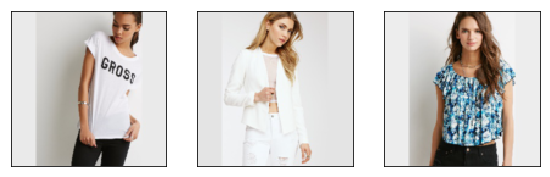

In [39]:
plot_gallery(X_batch[:3, 1], image_h, image_w, n_row=1, n_col=3)

In [128]:
autoencoder2 = torch.load('autoencoder.pt')

In [131]:
autoencoder.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (6): ReLU()
    (7): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (9): ReLU()
    (10): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (12): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (13): ReLU()
    (14): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1))
    (15): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (16): ReLU()
    (17): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1)

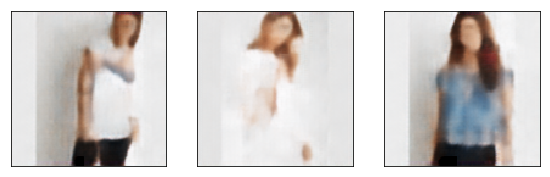

In [132]:
plot_gallery(autoencoder2(Variable(X_batch[:3, 1]).cuda())[0].cpu().data, image_h, image_w, n_row=1, n_col=3)